In [1]:
!export PYTHONUSERBASE=/projappl/project_2012638/

import sys
!{sys.executable} -m pip install --user pymannkendall -q
!{sys.executable} -m pip install --user tensorflow -q
!{sys.executable} -m pip install --user pyod -q
!{sys.executable} -m pip install --user 'tensorflow[and-cuda]' -q 
# Verify the installation:

In [2]:
import pandas as pd 
import psutil
import json
import matplotlib.pyplot as plt
import preprocess_functions as f 
import time 
import stats_helper as helper
import numpy as np
from scipy.stats import zscore
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.preprocessing import MinMaxScaler

In [3]:
PATH = 'realKnownCause/'
ERRORPATH = 'labels/combined_labels.json'
# load error data
with open(ERRORPATH, "r") as file:
    error_file = json.load(file)

In [4]:
file_names = f.get_all_files(PATH) # return all file paths
time_diffs, preprocessed_dfs = list(), list()
for file_name in file_names:
    time_diff, preprocessed_df = f.process_time_series(file_name, error_file) 
    time_diffs.append(time_diff)
    preprocessed_dfs.append(preprocessed_df)

def window_sizes_freq(time_diff):
    window_sizes = dict()
    window_sizes['daily'] = int(60*60*24 / time_diff)
    window_sizes['time_of_day'] = int(window_sizes['daily'] / 4)
    return window_sizes 

window_sizes = [window_sizes_freq(timediff) for timediff in time_diffs]

add_mul_def = [
    helper.add_or_mul(preprocessed_df, window_size) 
               for preprocessed_df, window_size in zip(preprocessed_dfs, window_sizes)
]
stats_df = pd.DataFrame({
    'file_name': file_names,
    'tod_window': [i[1] for i in add_mul_def],
    'daily_window': [i[0] for i in add_mul_def]
})

In [5]:
len(file_names)

7

# ARIMA

In [6]:
from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy import stats


def arima_model(series, stationary, seasonality, d, trace):
    return auto_arima(
        series,
        seasonal=seasonality,
        d=d,
        stationary=stationary,
        stepwise=True,
        suppress_warnings=True,
        error_action='ignore',
        trace=True
    ).order

def auto_arima_best_order(params):
    trace         = params['trace']
    df            = params['df'].copy()
    periods       = params['periods']
    model         = params['model']
    initial_stats = params['initial_stats']  # [Stationary, Trend, p1_Seasonality, p2_Seasonality]

    model_1, model_2   = model.iloc[0], model.iloc[1]
    period_1, period_2 = periods['time_of_day'], periods['daily']
    model_orders = []

    if initial_stats[0]:  # If data is already stationary
        if initial_stats[2] == initial_stats[3]:
            model_orders.append(arima_model(df['value'], True, False, 0, trace))
        else:
            model_orders.append(arima_model(df['value'], True, initial_stats[2], 0, trace))
            model_orders.append(arima_model(df['value'], True, initial_stats[3], 0, trace))
    
    else:  # Apply Box-Cox transformation if not stationary
        df['value_boxcox'], lam = stats.boxcox(df['value'])
        stationary, trend = helper.adf_test(df['value_boxcox'])
        p1_seasonality = helper.seasonality_test(df['value_boxcox'], model_1, period_1)
        p2_seasonality = helper.seasonality_test(df['value_boxcox'], model_2, period_2)
        print('Box-Cox applied.')
        if stationary:
            # redo the whole function, update initial_stats
            print('Stationary achieved.')
            print('New stats: ', [True, trend, p1_seasonality, p2_seasonality])
            return auto_arima_best_order({**params, 'initial_stats': [True, trend, p1_seasonality, p2_seasonality]})

        print('Stationary not achieved.')
        print('New stats: ', [stationary, trend, p1_seasonality, p2_seasonality])
        model_orders.append(arima_model(df['value_boxcox'], stationary, p1_seasonality, period_1, trace))
        model_orders.append(arima_model(df['value_boxcox'], stationary, p2_seasonality, period_2, trace))

    return model_orders


In [8]:
for i, preprocessed_df in enumerate(preprocessed_dfs): 
    if i != 6:
        continue
    df = preprocessed_df 
    add_mul_model = stats_df.iloc[i][1:] 
    periods = window_sizes[i] 
    params = {
        'df': df,
        'model': add_mul_model,
        'periods': periods,
        'trace': True,
    }
    params['initial_stats'] = helper.initial_stats(params)
    print('Processing: ', file_names[i])
    print('Initial stats: ', params['initial_stats'])
    start = time.time() 
    orders = auto_arima_best_order(params)
    end = time.time()
    print(f"{file_names[i]} done in {end-start} seconds")

Processing:  realKnownCause/ec2_request_latency_system_failure.csv
Initial stats:  [True, False, False, False]
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=17874.524, Time=2.70 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=18116.550, Time=0.08 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=18036.559, Time=0.14 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=18056.606, Time=0.31 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=42189.531, Time=0.05 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=17769.872, Time=2.77 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=17928.173, Time=0.43 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=18082.016, Time=0.77 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=17782.840, Time=3.26 sec
 ARIMA(0,0,3)(0,0,0)[0] intercept   : AIC=17876.687, Time=0.50 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=17934.696, Time=0.90 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=17764.671, Time=3.38 sec
 ARIMA(3,0,3)(0,0,0)[0] intercept   : AIC=

In [10]:
df_ec2 = preprocessed_dfs[-1].copy()
# Fit ARIMA model
arima_model = ARIMA(df_ec2['value'], order=(4,0,4))
arima_result = arima_model.fit()

# Compute residuals
df_ec2['fitted_values'] = arima_result.fittedvalues
df_ec2['residuals'] = df_ec2['value'] - df_ec2['fitted_values']

/PUHTI_TYKKY_FRQGCcR/miniconda/envs/env1/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


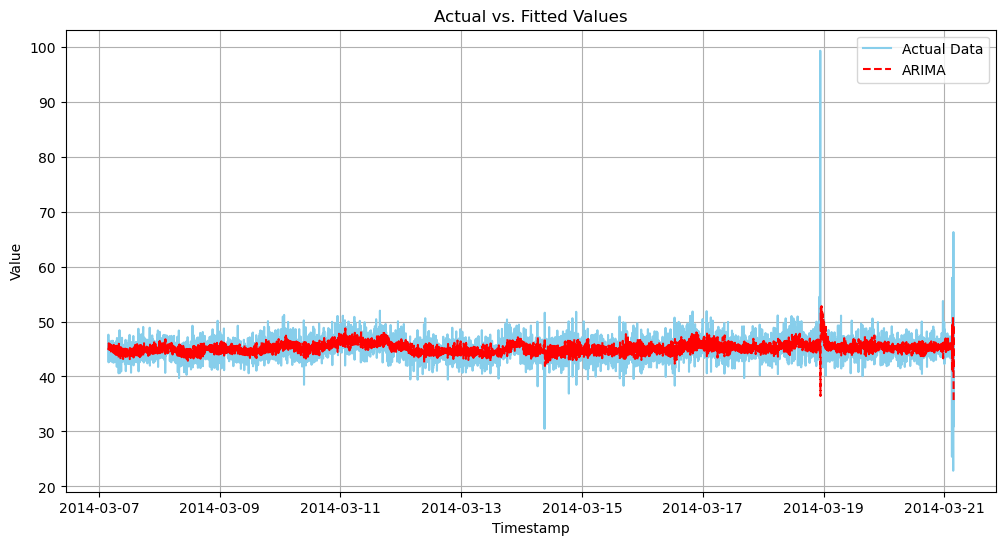

In [11]:
# Plot original data
plt.figure(figsize=(12, 6))
plt.plot(df_ec2['timestamp'], df_ec2['value'], label="Actual Data", color='skyblue')

# Plot fitted values (predictions from ARIMA)
plt.plot(df_ec2['timestamp'], df_ec2['fitted_values'], label="ARIMA", color='red', linestyle='dashed')

# Formatting
plt.xlabel("Timestamp")
plt.ylabel("Value")
plt.title("Actual vs. Fitted Values")
plt.legend()
plt.grid(True)
#plt.savefig('images/Arima/ec2_fitted_values.png')
# Show plot
plt.show()

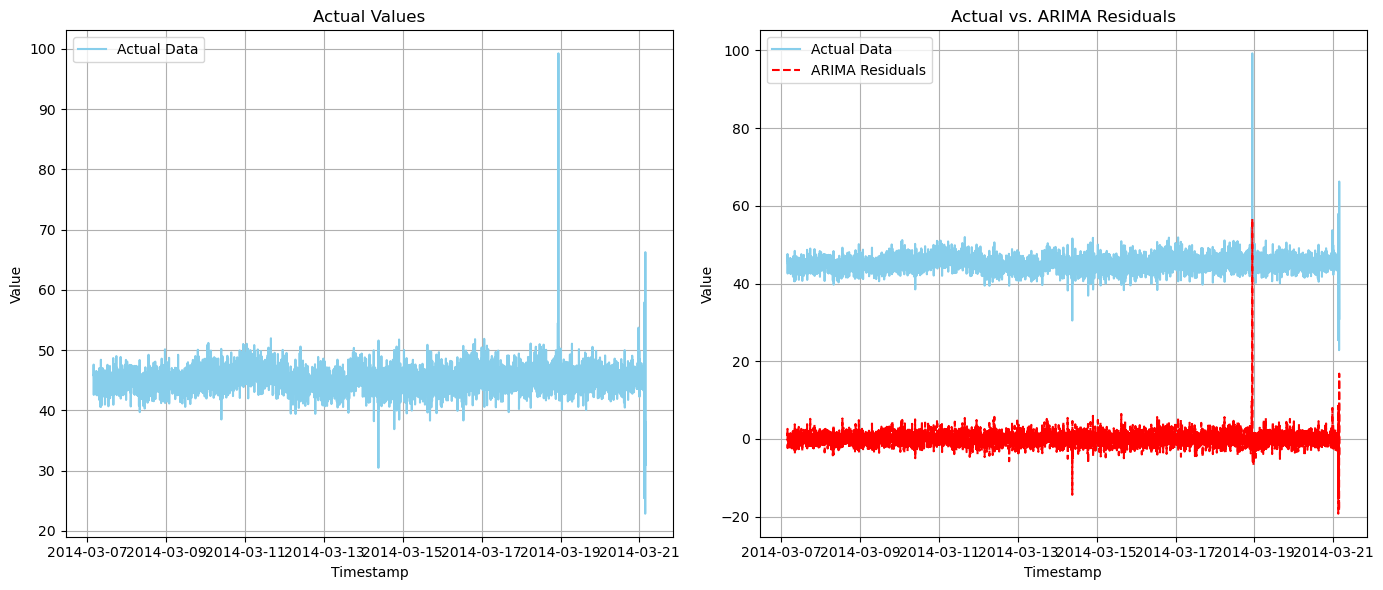

In [12]:
# Create a figure with two subplots
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Left plot: Only "value" column
ax[0].plot(df_ec2['timestamp'], df_ec2['value'], label="Actual Data", color='skyblue')
ax[0].set_xlabel("Timestamp")
ax[0].set_ylabel("Value")
ax[0].legend()
ax[0].set_title("Actual Values")
ax[0].grid(True)

# Right plot: "value" column and ARIMA residuals
ax[1].plot(df_ec2['timestamp'], df_ec2['value'], label="Actual Data", color='skyblue')
ax[1].plot(df_ec2['timestamp'], df_ec2['residuals'], label="ARIMA Residuals", color='red', linestyle='dashed')
ax[1].set_xlabel("Timestamp")
ax[1].set_ylabel("Value")
ax[1].set_title("Actual vs. ARIMA Residuals")
ax[1].legend()
ax[1].grid(True)

# Adjust layout for better spacing
plt.tight_layout()
#plt.savefig('images/Arima/ec2_compared_values.png')
# Show plot
plt.show()

# TIMEGAN

Rationale: Residuals will give you insight into where the model-generated data doesn't capture the actual data well. Large residuals can be seen as potential outliers in the original time series, which would be important for anomaly detection in the real data.

In [14]:
from timegan_v2_18 import timegan 
from metrics.discriminative_score import discriminative_score_metrics
from metrics.predictive_score import predictive_score_metrics

In [15]:
dfcopy = preprocessed_dfs[-1].copy()
freq = window_sizes[-1]['daily']
data = np.array(dfcopy['value']).reshape(-1, 1)
time_series = [data[i:i + freq] for i in range(len(data) - freq)]
ori_data = np.array(time_series)
parameters = {
            "hidden_dim": 30,
            "num_layer": 2,
            "iterations": 10000,
            "batch_size": 64,
            "module": 'lstm'
        }
generated_data = timegan(ori_data, parameters)
generated_values = np.array([seq[-1] for seq in generated_data]).flatten()
dfcopy.loc[freq:, 'generated_values'] = generated_values
dfcopy['generated_values'] = dfcopy['generated_values'].bfill() 
dfcopy['residual'] = dfcopy['value'] - dfcopy['generated_values']

I0000 00:00:1741596883.610599 1260045 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 31141 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:8a:00.0, compute capability: 7.0


Training completed


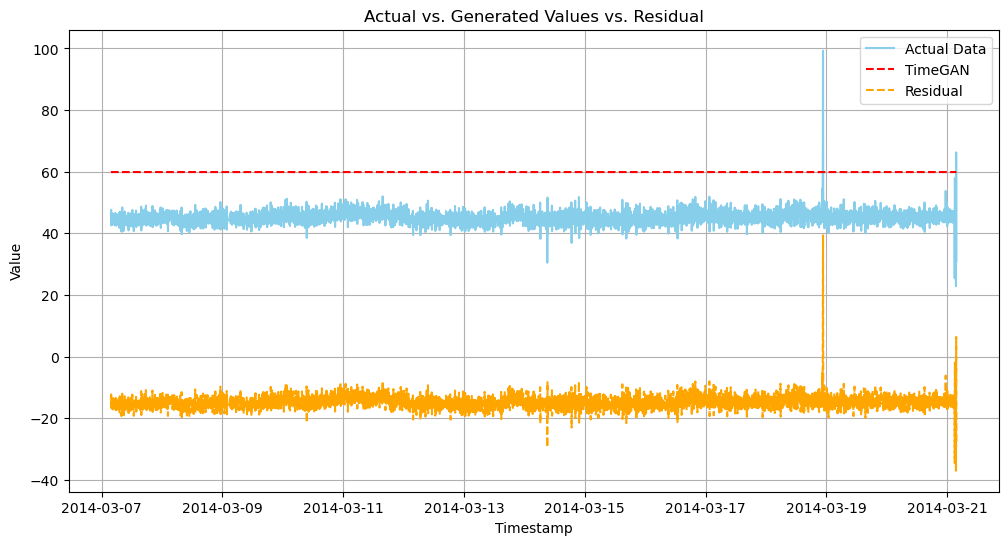

In [16]:
# Plot original data
plt.figure(figsize=(12, 6))
plt.plot(dfcopy['timestamp'], dfcopy['value'], label="Actual Data", color='skyblue')

# Plot fitted values (predictions from ARIMA)
plt.plot(dfcopy['timestamp'], dfcopy['generated_values'], label="TimeGAN", color='red', linestyle='dashed')
plt.plot(dfcopy['timestamp'], dfcopy['residual'], label="Residual", color='orange', linestyle='dashed')
# Formatting
plt.xlabel("Timestamp")
plt.ylabel("Value")
plt.title("Actual vs. Generated Values vs. Residual")
plt.legend()
plt.grid(True)
#plt.savefig('images/ec2_timegan_residual.png')
# Show plot
plt.show()

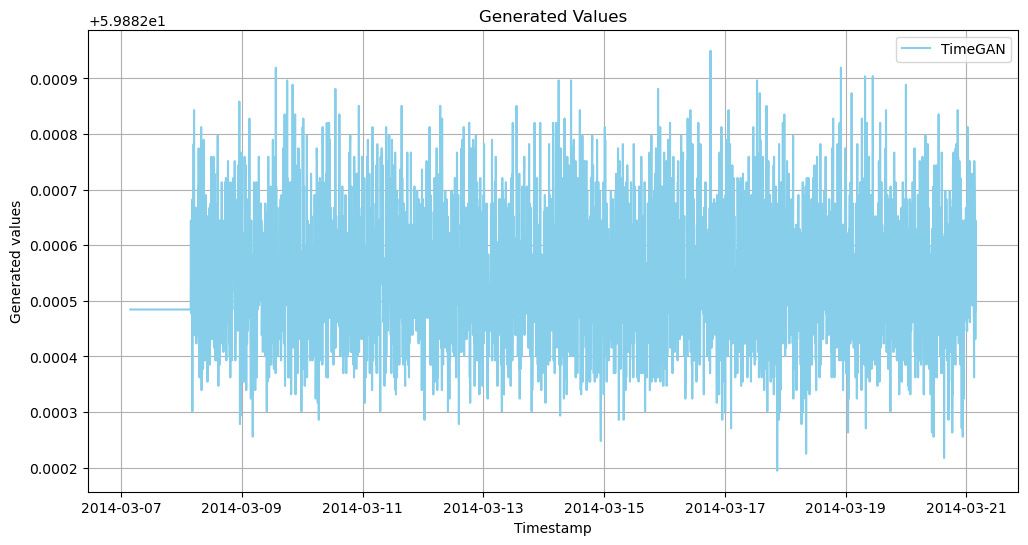

In [17]:
# Plot original data
plt.figure(figsize=(12, 6))

# Plot fitted values (predictions from ARIMA)
plt.plot(dfcopy['timestamp'], dfcopy['generated_values'], label="TimeGAN", color='skyblue')
# Formatting
plt.xlabel("Timestamp")
plt.ylabel("Generated values")
plt.title("Generated Values")
plt.legend()
plt.grid(True)
#plt.savefig('images/ec2_generated_timegan.png')
# Show plot
plt.show()

In [29]:
print(f'Discriminative score: {final_discri_score}')
print(f'Predictive score: {final_pred_score}')

Discriminative score: 0.3
Predictive score: 19.7101993560791


In [28]:
# Discriminative score for the sequence
metric_iteration = 5

discriminative_scores = [
    discriminative_score_metrics(ori_data, generated_data, iterations=200, batch_size=batch_size, patience=10)
    for _ in range(metric_iteration)
]

final_discri_score = np.round(np.mean(discriminative_scores), 4)


# Predictive score for the sequence
predictive_scores = [
    predictive_score_metrics(ori_data, generated_data, epochs=50, batch_size=batch_size, n_splits=5)
    for _ in range(metric_iteration)
]

final_pred_score = np.round(np.mean(predictive_scores), 4)
        

Epoch 1/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.5021 - loss: 0.7750 - val_accuracy: 0.5000 - val_loss: 0.7643
Epoch 2/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.5015 - loss: 0.7591 - val_accuracy: 0.5000 - val_loss: 0.7491
Epoch 3/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.5043 - loss: 0.7427 - val_accuracy: 0.5000 - val_loss: 0.7359
Epoch 4/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.5050 - loss: 0.7300 - val_accuracy: 0.5000 - val_loss: 0.7249
Epoch 5/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.4987 - loss: 0.7231 - val_accuracy: 0.5000 - val_loss: 0.7159
Epoch 6/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.5014 - loss: 0.7134 - val_accuracy: 0.5000 - val_loss: 0.7089
Epoch 7/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.4934 - loss: 0.7098 - val_accuracy: 0.5000 - val_loss: 0.7037
Epoch 8/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.4971 - loss: 0.7035 - val_accuracy: 0.

# ECOD

In [18]:
from pyod.models.ecod import ECOD

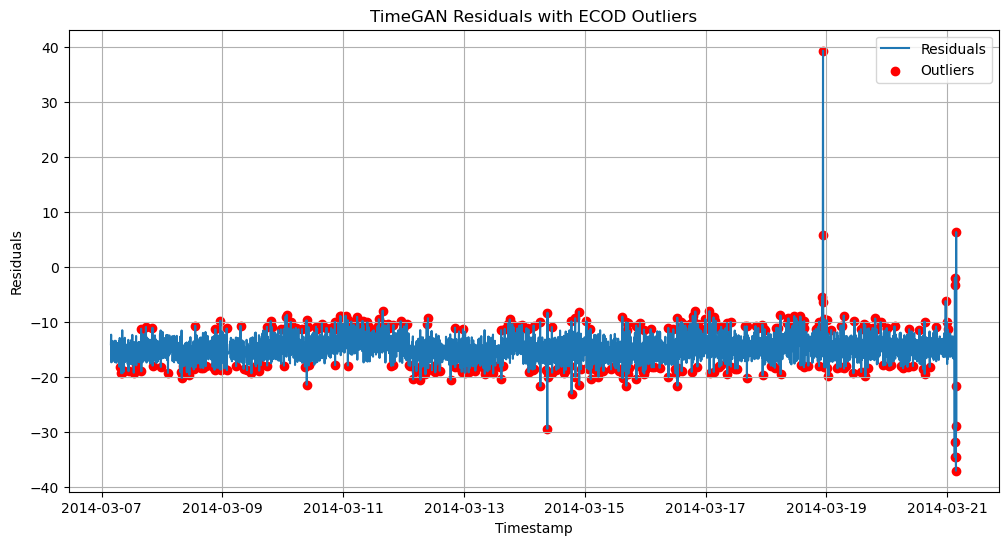

In [23]:
target = 'residual' 

## TimeGAN
feature = dfcopy[[target]]
# Step 1: Initialize the ECOD model
ecod = ECOD()

# Step 2: Fit the ECOD model on the entire dataset
ecod.fit(feature)

# Step 3: Get outlier scores for the dataset
outlier_scores = ecod.decision_function(feature)

dfcopy['ecod_label'] = ecod.labels_

# Visualize the residuals and outliers
plt.figure(figsize=(12, 6))
plt.plot(dfcopy['timestamp'], dfcopy[target], label='Residuals')
plt.scatter(dfcopy['timestamp'][dfcopy['ecod_label'] == 1], dfcopy[target][dfcopy['ecod_label'] == 1], color='red', label='Outliers')
plt.xlabel('Timestamp')
plt.ylabel('Residuals')
plt.title('TimeGAN Residuals with ECOD Outliers')
plt.legend()
plt.grid(True)
plt.show()

[10.86453068  8.84962766  6.93188839  6.90371751 11.40352718  8.5413263
  5.9592559  10.45906557  6.44168205  7.51657781  5.76873758 14.04258451
  5.67912542 10.01723282]


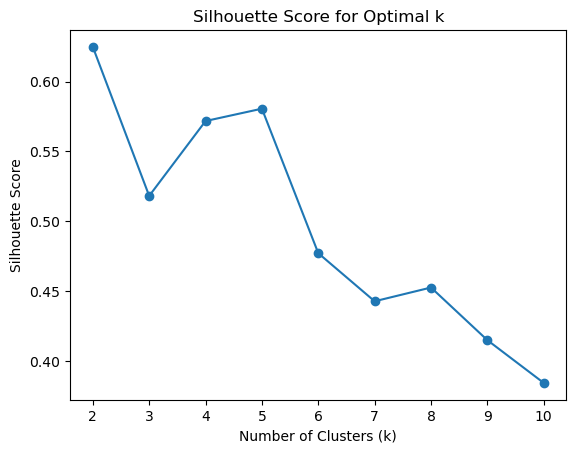

Optimal k (Silhouette Method): 2
Cluster labels for each chunk: [1 0 0 0 1 0 0 1 0 0 0 1 0 1]


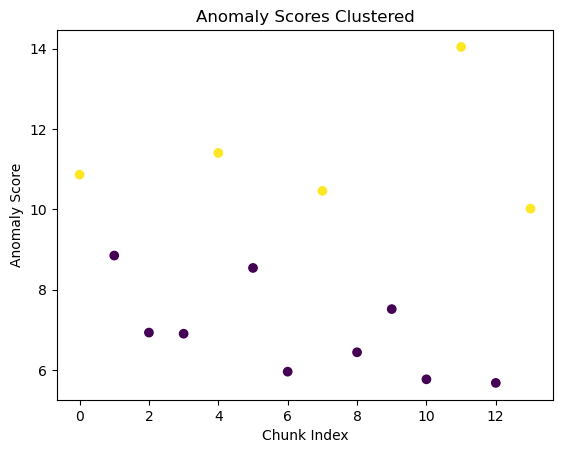

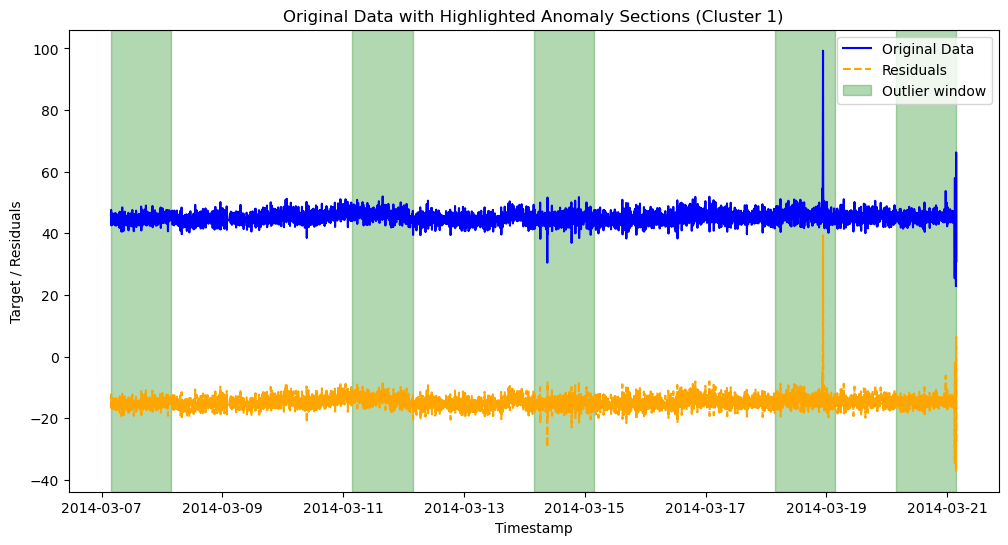

In [62]:
from scipy.stats import skew, kurtosis
def compute_chunk_features(chunk):
    # Calculate robust statistical features
    mean = np.mean(chunk)
    std_dev = np.std(chunk)
    skewness = skew(chunk)
    kurt = kurtosis(chunk)
    range_val = np.max(chunk) - np.min(chunk)
    median = np.median(chunk)
    
    # Ensure values are scalars
    return {
        'mean': float(mean),
        'std_dev': float(std_dev),
        'skewness': float(skewness.item()),
        'kurtosis': float(kurt.item()),
        'range': float(range_val),
        'median': float(median)
    }

values = dfcopy[['value']].values
chunks = [values[i:i+288] for i in range(0, len(values)-288, 288)]
# Compute features for each chunk
chunk_features = [compute_chunk_features(chunk) for chunk in chunks]
# Convert chunk features to a numpy array for ECOD input
features_matrix = np.array([[chunk['mean'], chunk['std_dev'], chunk['skewness'], chunk['kurtosis'],
                             chunk['range'], chunk['median']] for chunk in chunk_features])
# Initialize ECOD model
ecod = ECOD()

# Fit ECOD model on the chunk features
ecod.fit(features_matrix)

# Get anomaly scores for each chunk
anomaly_scores = ecod.decision_function(features_matrix)

print(anomaly_scores)



from sklearn.cluster import KMeans

# Assuming 'anomaly_scores' is a 1D array or a column vector of scores
# Reshape the anomaly scores to be a 2D array for clustering
anomaly_scores = anomaly_scores.reshape(-1, 1)

# Find best K using silhouette 
from sklearn.metrics import silhouette_score


# Range of k values to try
k_values = range(2, 11)  # Silhouette score is only defined for k > 1
silhouette_scores = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(anomaly_scores)
    score = silhouette_score(anomaly_scores, kmeans.labels_)
    silhouette_scores.append(score)

# Plot Silhouette Scores
plt.plot(k_values, silhouette_scores, marker='o')
plt.title('Silhouette Score for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.show()

# Find the k with the highest silhouette score
best_k = k_values[silhouette_scores.index(max(silhouette_scores))]
print(f"Optimal k (Silhouette Method): {best_k}")


# Apply K-means clustering (you can change n_clusters as needed)
kmeans = KMeans(n_clusters=best_k, random_state=42)  # Example with 2 clusters
kmeans.fit(anomaly_scores)

# Get the cluster labels for each anomaly score
cluster_labels = kmeans.labels_

# Print the cluster labels for each chunk
print("Cluster labels for each chunk:", cluster_labels)

# Visualize the clustering result (optional)
plt.scatter(range(len(anomaly_scores)), anomaly_scores, c=cluster_labels, cmap='viridis')
plt.title("Anomaly Scores Clustered")
plt.xlabel("Chunk Index")
plt.ylabel("Anomaly Score")
plt.show()

# Plot the original data
plt.figure(figsize=(12, 6))
plt.plot(dfcopy['timestamp'], dfcopy['value'], label='Original Data', color='blue')
plt.plot(dfcopy['timestamp'], dfcopy['residual'], label='Residuals', color='orange', linestyle='dashed')

# Loop over the chunks and color the background where cluster label is 1
for chunk_idx in range(len(cluster_labels)):
    if cluster_labels[chunk_idx] == 1:
        # Define the start and end index of the chunk in terms of dfcopy
        chunk_start = chunk_idx * 288
        chunk_end = chunk_start + 288
        
        # Ensure we do not exceed the length of dfcopy
        if chunk_end > len(dfcopy):
            chunk_end = len(dfcopy)
        
        # Color the background of this chunk (use axvspan for background coloring)
        plt.axvspan(dfcopy['timestamp'].iloc[chunk_start], dfcopy['timestamp'].iloc[chunk_end-1], 
                    color='green', alpha=0.3, label=f'Outlier window' if chunk_idx == 0 else "")

# Customize the plot
plt.title("Original Data with Highlighted Anomaly Sections (Cluster 1)")
plt.xlabel("Timestamp")
plt.ylabel("Target / Residuals")
plt.legend(loc='upper right')
plt.show()

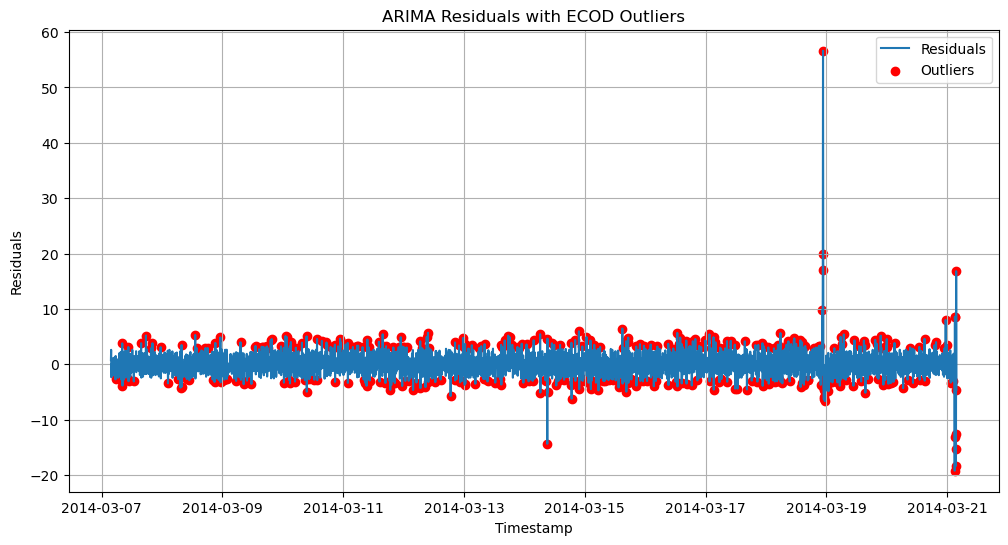

In [36]:
## TimeGAN
feature = df_ec2[['residuals']]
# Step 1: Initialize the ECOD model
ecod = ECOD()

# Step 2: Fit the ECOD model on the entire dataset
ecod.fit(feature)

# Step 3: Get outlier scores for the dataset
outlier_scores = ecod.decision_function(feature)

df_ec2['ecod_label'] = ecod.labels_

# Visualize the residuals and outliers
plt.figure(figsize=(12, 6))
plt.plot(df_ec2['timestamp'], df_ec2['residuals'], label='Residuals')
plt.scatter(df_ec2['timestamp'][df_ec2['ecod_label'] == 1], df_ec2['residuals'][df_ec2['ecod_label'] == 1], color='red', label='Outliers')
plt.xlabel('Timestamp')
plt.ylabel('Residuals')
plt.title('ARIMA Residuals with ECOD Outliers')
plt.legend()
plt.grid(True)
plt.show()

[10.86453068  8.84962766  6.93188839  6.90371751 11.40352718  8.5413263
  5.9592559  10.45906557  6.44168205  7.51657781  5.76873758 14.04258451
  5.67912542 10.01723282]


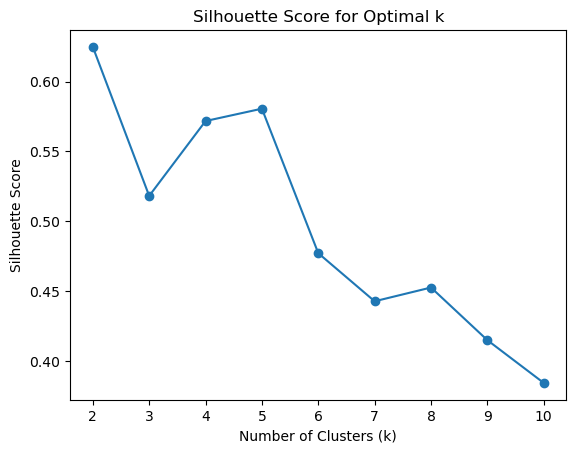

Optimal k (Silhouette Method): 2
Cluster labels for each chunk: [1 0 0 0 1 0 0 1 0 0 0 1 0 1]


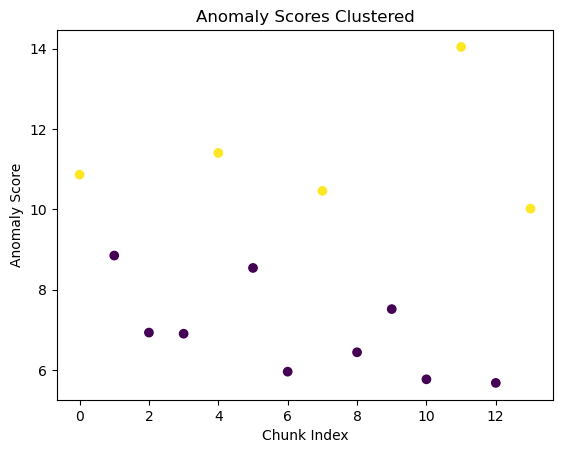

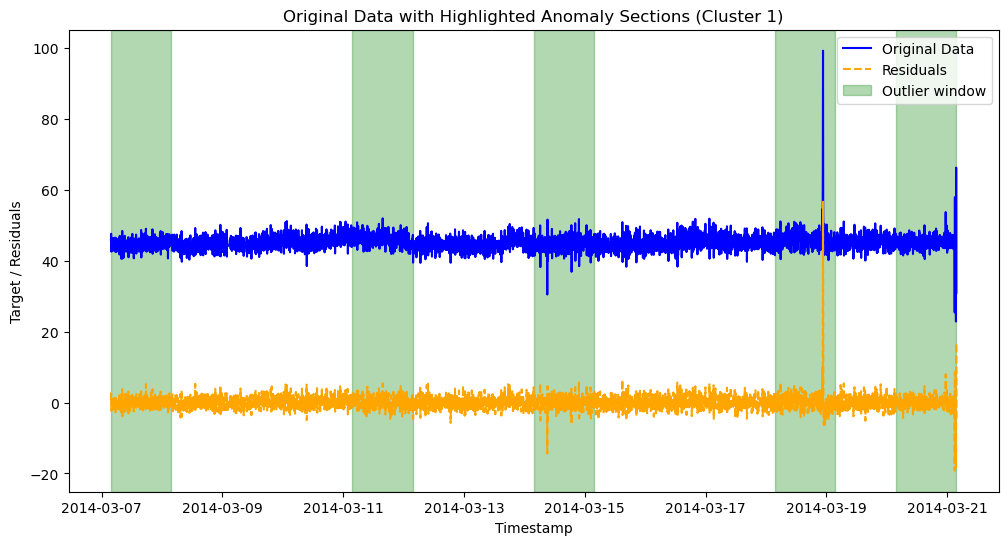

In [64]:
from scipy.stats import skew, kurtosis
def compute_chunk_features(chunk):
    # Calculate robust statistical features
    mean = np.mean(chunk)
    std_dev = np.std(chunk)
    skewness = skew(chunk)
    kurt = kurtosis(chunk)
    range_val = np.max(chunk) - np.min(chunk)
    median = np.median(chunk)
    
    # Ensure values are scalars
    return {
        'mean': float(mean),
        'std_dev': float(std_dev),
        'skewness': float(skewness.item()),
        'kurtosis': float(kurt.item()),
        'range': float(range_val),
        'median': float(median)
    }

values = df_ec2[['value']].values
chunks = [values[i:i+288] for i in range(0, len(values)-288, 288)]
# Compute features for each chunk
chunk_features = [compute_chunk_features(chunk) for chunk in chunks]
# Convert chunk features to a numpy array for ECOD input
features_matrix = np.array([[chunk['mean'], chunk['std_dev'], chunk['skewness'], chunk['kurtosis'],
                             chunk['range'], chunk['median']] for chunk in chunk_features])
# Initialize ECOD model
ecod = ECOD()

# Fit ECOD model on the chunk features
ecod.fit(features_matrix)

# Get anomaly scores for each chunk
anomaly_scores = ecod.decision_function(features_matrix)

print(anomaly_scores)



from sklearn.cluster import KMeans

# Assuming 'anomaly_scores' is a 1D array or a column vector of scores
# Reshape the anomaly scores to be a 2D array for clustering
anomaly_scores = anomaly_scores.reshape(-1, 1)

# Find best K using silhouette 
from sklearn.metrics import silhouette_score


# Range of k values to try
k_values = range(2, 11)  # Silhouette score is only defined for k > 1
silhouette_scores = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(anomaly_scores)
    score = silhouette_score(anomaly_scores, kmeans.labels_)
    silhouette_scores.append(score)

# Plot Silhouette Scores
plt.plot(k_values, silhouette_scores, marker='o')
plt.title('Silhouette Score for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.show()

# Find the k with the highest silhouette score
best_k = k_values[silhouette_scores.index(max(silhouette_scores))]
print(f"Optimal k (Silhouette Method): {best_k}")


# Apply K-means clustering (you can change n_clusters as needed)
kmeans = KMeans(n_clusters=best_k, random_state=42)  # Example with 2 clusters
kmeans.fit(anomaly_scores)

# Get the cluster labels for each anomaly score
cluster_labels = kmeans.labels_

# Print the cluster labels for each chunk
print("Cluster labels for each chunk:", cluster_labels)

# Visualize the clustering result (optional)
plt.scatter(range(len(anomaly_scores)), anomaly_scores, c=cluster_labels, cmap='viridis')
plt.title("Anomaly Scores Clustered")
plt.xlabel("Chunk Index")
plt.ylabel("Anomaly Score")
plt.show()

# Plot the original data
plt.figure(figsize=(12, 6))
plt.plot(df_ec2['timestamp'], df_ec2['value'], label='Original Data', color='blue')
plt.plot(df_ec2['timestamp'], df_ec2['residuals'], label='Residuals', color='orange', linestyle='dashed')

# Loop over the chunks and color the background where cluster label is 1
for chunk_idx in range(len(cluster_labels)):
    if cluster_labels[chunk_idx] == 1:
        # Define the start and end index of the chunk in terms of dfcopy
        chunk_start = chunk_idx * 288
        chunk_end = chunk_start + 288
        
        # Ensure we do not exceed the length of dfcopy
        if chunk_end > len(dfcopy):
            chunk_end = len(dfcopy)
        
        # Color the background of this chunk (use axvspan for background coloring)
        plt.axvspan(df_ec2['timestamp'].iloc[chunk_start], df_ec2['timestamp'].iloc[chunk_end-1], 
                    color='green', alpha=0.3, label=f'Outlier window' if chunk_idx == 0 else "")

# Customize the plot
plt.title("Original Data with Highlighted Anomaly Sections (Cluster 1)")
plt.xlabel("Timestamp")
plt.ylabel("Target / Residuals")
plt.legend(loc='upper right')
plt.show()